<a href="https://colab.research.google.com/github/bwilder95/MIT_Intro_to_ML/blob/main/Kmeans_SNOW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# mount google drive
from google.colab import drive
from sklearn.cluster import KMeans 
import os
from osgeo import gdal
import numpy as np 
drive.mount('/content/gdrive')
!ls

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
classified.tif	gdrive	sample_data  TERRA_scaled.tif


In [ ]:
# load 30-m Landsat image from mountains near Lake Tahoe
naip_fn = './gdrive/My Drive/Tahoe_Snow.tif' 
driverTiff = gdal.GetDriverByName('GTiff') 
image = gdal.Open(naip_fn,gdal.GA_ReadOnly) 
print(image)

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7f62bfbd3a80> >


In [ ]:
# read number of bands and arrays of data
nbands = image.RasterCount
data = np.empty((image.RasterXSize*image.RasterYSize, nbands))

In [ ]:
# flatten to 1-d array, all data in one array
for i in range(1, nbands+1): 
    band = image.GetRasterBand(i).ReadAsArray() 
    data[:, i-1] = band.flatten()

In [ ]:
# k-means classification (Snow and no snow)
# remove inf and NaN values
data[data > 1e308] = 0
data[np.isnan(data)] = 0.0
km = KMeans(n_clusters=2) 
km.fit(data) 
km.predict(data)

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [ ]:
# retrieve results using "labels"
out_dat = km.labels_.reshape((image.RasterYSize,\
image.RasterXSize))

In [ ]:
# save classified tif
driverTiff = gdal.GetDriverByName('GTiff')
clfds = driverTiff.Create('./classified.tif',\
image.RasterXSize, image.RasterYSize, 1, gdal.GDT_Float32)
clfds.SetGeoTransform(image.GetGeoTransform())
clfds.SetProjection(image.GetProjection())
clfds.GetRasterBand(1).SetNoDataValue(-9999.0)
clfds.GetRasterBand(1).WriteArray(out_dat)
clfds = None

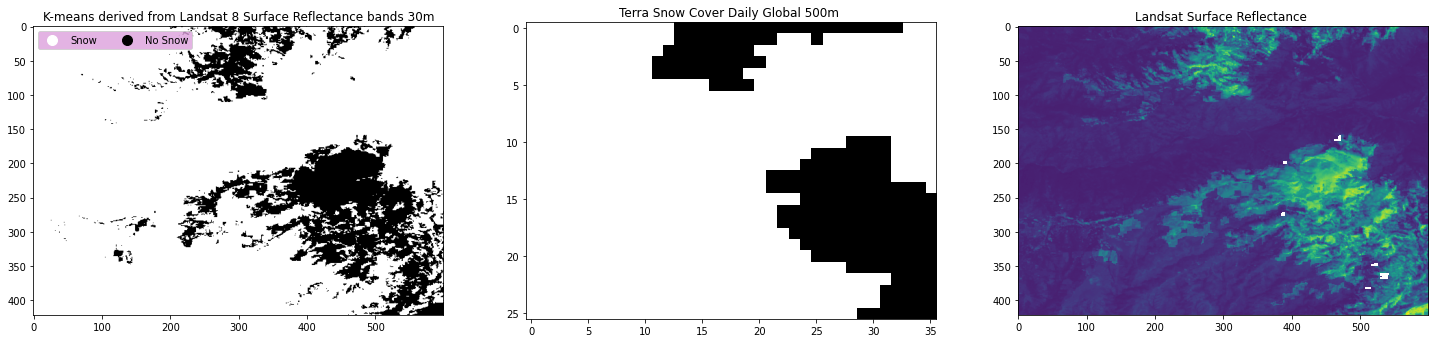

In [ ]:
# display results of kmeans classification
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as mpatches
image2 = gdal.Open('./classified.tif').ReadAsArray() 

# sub plots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(25,25))
colors = ["k", "w"]
texts = ["Snow", "No Snow"]
patches = [ plt.plot([],[], marker="o", ms=10, ls="", mec=None, color=colors[i], 
            label="{:s}".format(texts[i]) )[0]  for i in range(len(texts)) ]
ax1.legend(handles=patches,loc='upper left', ncol=2, facecolor="plum", numpoints=1 )
ax1.imshow(image2, cmap="binary")
ax1.title.set_text('K-means derived from Landsat 8 Surface Reflectance bands 30m')

# compare to Terra Snow Cover product
image1 = gdal.Open('./gdrive/My Drive/Tahoe_Snow_terra.tif', gdal.GA_ReadOnly)
band = image1.GetRasterBand(1)
arr = band.ReadAsArray()
arr[arr > 0] = 1
ax2.imshow(arr, cmap = "binary")
ax2.title.set_text('Terra Snow Cover Daily Global 500m ')

# compare to actual image
image3 = gdal.Open('./gdrive/My Drive/Tahoe_Snow.tif', gdal.GA_ReadOnly)
band3 = image3.GetRasterBand(1)
arr3 = band3.ReadAsArray()
ax3.imshow(arr3)
ax3.title.set_text('Landsat Surface Reflectance ')

In [ ]:
# reproject Terra to same scale as ML image
# Source (TERRA)
src_filename = r'./gdrive/My Drive/Tahoe_Snow_terra.tif'
src = gdal.Open(src_filename, gdal.GA_ReadOnly)
src_proj = src.GetProjection()
src_geotrans = src.GetGeoTransform()

# We want a section of source that matches ML IMAGE:
match_filename = r'./classified.tif'
match_ds = gdal.Open(match_filename, gdal.GA_ReadOnly)
match_proj = match_ds.GetProjection()
match_geotrans = match_ds.GetGeoTransform()
wide = match_ds.RasterXSize
high = match_ds.RasterYSize

# Output / destination
dst_filename = r'./TERRA_scaled.tif'
dst = gdal.GetDriverByName('Gtiff').Create(dst_filename, wide, high, 1, gdal.GDT_Float32)
dst.SetGeoTransform( match_geotrans )
dst.SetProjection( match_proj)

# Do the work
gdal.ReprojectImage(src, dst, src_proj, match_proj, gdal.GRA_NearestNeighbour)

del dst # Flush

print ("finish")

finish


In [ ]:
# confirm shape is same
test = gdal.Open('./classified.tif').ReadAsArray() 
print('ML shape is: ' + str(test.shape))
print(test)
actual = gdal.Open('./TERRA_scaled.tif').ReadAsArray() 
print('TERRA shape is: '+ str(actual.shape))
actual[actual > 0] = 1 # convert TERRA dataset to binary
print(actual)

ML shape is: (422, 600)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]]
TERRA shape is: (422, 600)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]]


In [ ]:
# flatten to 1-d again (TEST)
naip_fn = './classified.tif' 
driverTiff = gdal.GetDriverByName('GTiff') 
test = gdal.Open(naip_fn,gdal.GA_ReadOnly) 
nbands = test.RasterCount
testdata = np.empty((test.RasterXSize*test.RasterYSize, nbands))
for i in range(1, nbands+1): 
    testband = test.GetRasterBand(i).ReadAsArray() 
    testdata[:, i-1] = testband.flatten()
#testdata[testdata != 0] = 1 # make sure ML binary
print(testdata)

[[0.]
 [0.]
 [0.]
 ...
 [1.]
 [1.]
 [1.]]


In [ ]:
# flatten to 1-d again (ACTUAL)
naip_fn = './TERRA_scaled.tif' 
driverTiff = gdal.GetDriverByName('GTiff') 
actual = gdal.Open(naip_fn,gdal.GA_ReadOnly) 
nbands = actual.RasterCount
actualdata = np.empty((actual.RasterXSize*actual.RasterYSize, nbands))
for i in range(1, nbands+1): 
    actualband = actual.GetRasterBand(i).ReadAsArray() 
    actualdata[:, i-1] = actualband.flatten()
actualdata[actualdata > 0] = 1 # convert TERRA dataset to binary


print(actualdata)

[[0.]
 [0.]
 [0.]
 ...
 [1.]
 [1.]
 [1.]]


In [ ]:
# import sklearn
from sklearn.metrics import accuracy_score

# remove inf and NaN
testdata[testdata > 1e308] = 0
testdata[np.isnan(testdata)] = 0.0
actualdata[actualdata > 1e308] = 0
actualdata[np.isnan(actualdata)] = 0.0


# test data
accuracy_score(actualdata, testdata)

0.8749249605055293